In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

import os
import numpy as np
import matplotlib.pyplot as plt

# Methoden & Technieken

## Image Generation
14 Dec 2022

### Inhoud

- Deep Dream
- Style Transfer

### Deep Dream

- Google, 2015

- Gradient Ascent om activatie van lagen uit een voorgetraind model te maximaliseren
  - Gewogen gemiddelde van $L_2$ norm van activaties van alle filters in meerdere lagen
  - Startpunt is een invoerplaatje
- Meerdere stappen (*octaves*) van bewerkingen

We maximaliseren de volgende *loss*-functie:

$$
Loss = \sum_{i=1}^n w_i || layer_i ||_2,
$$

hier is $layer_i$ de activatie van de $i^{de}$ laag, $|| \cdot ||_2$ is de $L_2$ norm (kwadraatsom van de activaties) en $w_i$ zijn gewichten.

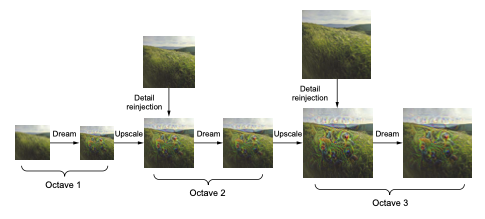

Als voorbeeld gebruiken we het uitzicht uit mijn raam, samen met VGG16. (Het boek gebruikt Inception, maar ik vind VGG er leuker uitzien.)

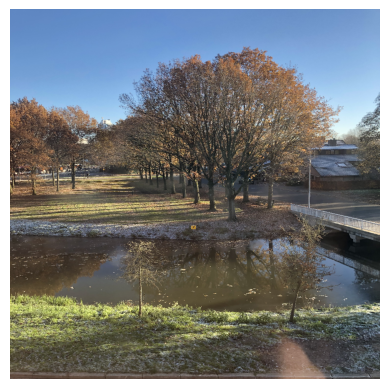

In [2]:
target_size = (360,360)
fullPath = os.path.abspath("./fotouitraam.png") 
base_image_path = keras.utils.get_file(
    "fotouitraam.png", origin="file://"+fullPath)

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path, target_size = (1024,1024)))
plt.show()

In [3]:
model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
#model = inception_v3.InceptionV3(weights="imagenet", include_top=False)
model.summary()

Metal device set to: Apple M1


2022-12-14 18:59:24.890363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 18:59:24.890445: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [4]:
step = 1.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = None
lost_weight = 0.0

layer_settings = {
    #"mixed1": 1.0,
    #"mixed2": 1.0,
    #"mixed3": 1.0,
    #"mixed4": 1.0,
    #"mixed5": 1.5,
    #"mixed6": 2.0,
    #"mixed7": 2.5,
    #"mixed8": 3.0,
    #"mixed9": 2.0,
    #"mixed10": 4.0,
    "block1_pool": 0.5,
    "block2_pool": 1.0,
    "block3_pool": 1.5,
    "block4_pool": 2.0,
    "block5_pool": 1.0,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [5]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [6]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            print(f"Loss at step {i} exceeded max loss: {loss:.2f} > {max_loss}")
            break
        if i%10 == 9:
            print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [7]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size = target_size)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Opties: resolutie (360, 360), gewichten voor de vijf blocks (0.5, 1.0, 1.5, 2.0, 1.0), 30 gradient ascent stappen per octave, 3 octaves.

In [8]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_weight*lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)



Processing octave 0 with shape (183, 183)


2022-12-14 18:59:25.856860: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-14 18:59:25.857076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 9: 531.44
... Loss value at step 19: 768.34
... Loss value at step 29: 1030.67
Processing octave 1 with shape (257, 257)


2022-12-14 18:59:28.053224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 9: 727.05
... Loss value at step 19: 894.22
... Loss value at step 29: 1066.57
Processing octave 2 with shape (360, 360)


2022-12-14 18:59:31.617196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 9: 711.90
... Loss value at step 19: 825.19
... Loss value at step 29: 941.53


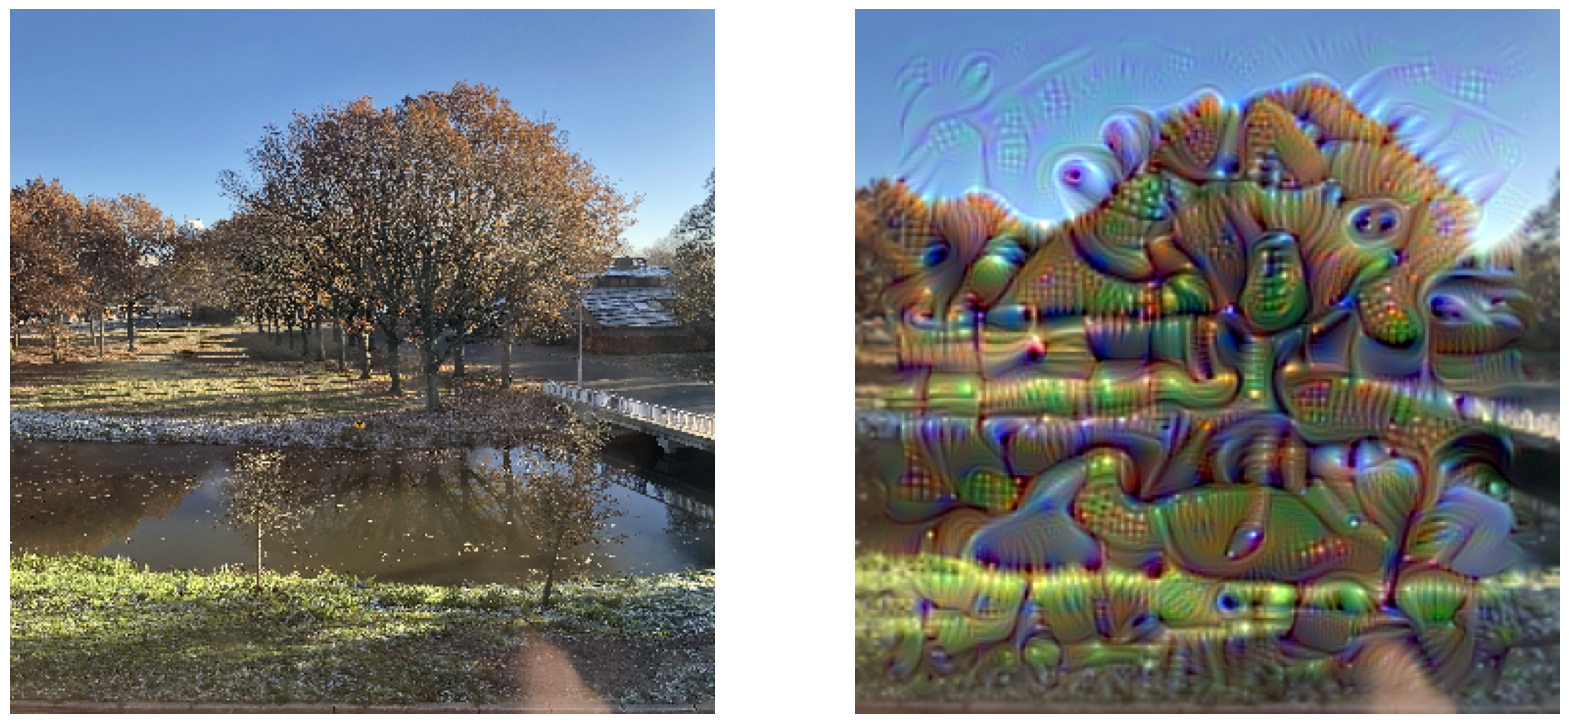

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path, target_size = target_size))
plt.subplot(1,2,2)
plt.imshow(deprocess_image(img.numpy()))
plt.axis("off")
plt.show()

In [10]:
keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Een paar andere voorbeelden van wikipedia en het boek:

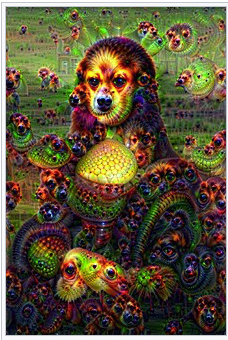

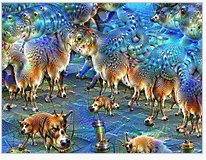

### Style Transfer

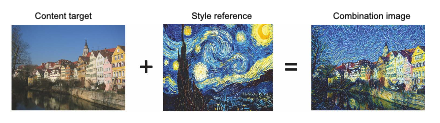

Idee -- definieer een *loss* functie die:
- afwijkingen van de *stijl* van het referentie beeld afstraft, en
- afwijkingen van de *inhoud* van het originele beeld afstraft.

$$
Loss = ||stijl(ref) - stijl(img)|| + ||inhoud(ori) - inhoud(img)||
$$
waar $||\cdot||$ een of andere afstandmaat is (bijvoorbeeld $L_2$).

Vind vervolgens een $img$ dat deze loss minimaliseert.

Probleem: hoe formuleer je, wiskundig, afwijkingen van stijl en inhoud?

Neem een groot voorgetraind beeldclassificatienetwerk, bijvoorbeeld Inception of VGG:
- Eerdere lagen kijken naar fijne details
  - Realistisch?
  - Grove verf vegen?
  - Stijl!
- Latere lagen kijken naar grotere objecten
  - Inhoud!
  
We kunnen dus activaties van lagen van zo'n netwerk gebruiken.